# AutoEncoder Tutorial

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## Data Cleaning

In [2]:
wd = os.getcwd()
# datafolder = os.path.join(wd, "AutoEncoder")
datafolder = os.path.join(wd, "data")
datapath = os.path.join(datafolder, "creditcard.csv")

df = pd.read_csv(datapath)

In [3]:
# Making the Time values appropriate for future work 
df['Time'] = df['Time'].apply(lambda x : (x / 3600) % 24) 
  
# Separating the normal and fraudulent transactions 
fraud = df[df['Class']== 1] 
# normal = df[df['Class']== 0]
# normal = df[df['Class']== 0].sample(2500)
normal = df[df['Class']== 0].sample(250000)

# Reducing the dataset because of machinery constraints 
df = pd.concat([normal, fraud], ignore_index=True)

# Separating the dependent and independent variables 
y = df['Class'] 
X = df.drop('Class', axis = 1)

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,...,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000,250492.000000
mean,14.540351,-0.001451,-0.000504,-0.003074,0.002434,-0.000438,0.000549,-0.000448,0.000981,-0.001322,...,-0.000032,0.000175,0.000136,0.000433,-0.000426,0.000094,0.000029,-0.000050,88.740703,0.001964
std,5.843074,1.963660,1.657922,1.524863,1.418794,1.386504,1.335327,1.250784,1.197292,1.100551,...,0.733907,0.725753,0.623733,0.605827,0.521748,0.481955,0.404934,0.329439,252.623079,0.044275
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,10.600000,-0.919991,-0.600193,-0.893530,-0.847152,-0.692452,-0.769559,-0.554607,-0.208446,-0.643186,...,-0.228426,-0.542930,-0.161864,-0.354753,-0.317659,-0.326838,-0.070950,-0.052996,5.550000,0.000000
50%,15.013611,0.018110,0.065643,0.177854,-0.018304,-0.053877,-0.274063,0.039906,0.022629,-0.052082,...,-0.029235,0.006830,-0.011066,0.041108,0.015990,-0.052014,0.001353,0.011244,22.000000,0.000000
75%,19.327222,1.315593,0.804361,1.025580,0.744831,0.612521,0.398831,0.570549,0.328126,0.595774,...,0.186930,0.529317,0.147635,0.440675,0.350549,0.241048,0.091075,0.078465,77.420000,0.000000
max,23.999444,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,5.852484,3.517346,31.612198,33.847808,25691.160000,1.000000


In [5]:
def tsne_plot(x, y): 
      
    # Setting the plotting background 
    sns.set_theme(style ="whitegrid") 
      
    tsne = TSNE(n_components = 2, random_state = 0) 
      
    # Reducing the dimensionality of the data 
    X_transformed = tsne.fit_transform(x) 
  
    plt.figure(figsize =(12, 8)) 
      
    # Building the scatter plot 
    plt.scatter(X_transformed[np.where(y == 0), 0],  
                X_transformed[np.where(y == 0), 1], 
                marker ='o', color ='y', linewidth =1, 
                alpha = 0.8, label ='Normal') 
    plt.scatter(X_transformed[np.where(y == 1), 0], 
                X_transformed[np.where(y == 1), 1], 
                marker ='o', color ='k', linewidth =1, 
                alpha = 0.8, label ='Fraud') 
  
    # Specifying the location of the legend 
    plt.legend(loc ='best') 
      
    # Plotting the reduced data 
    plt.show() 

## Plotting Pre-encdoed Data

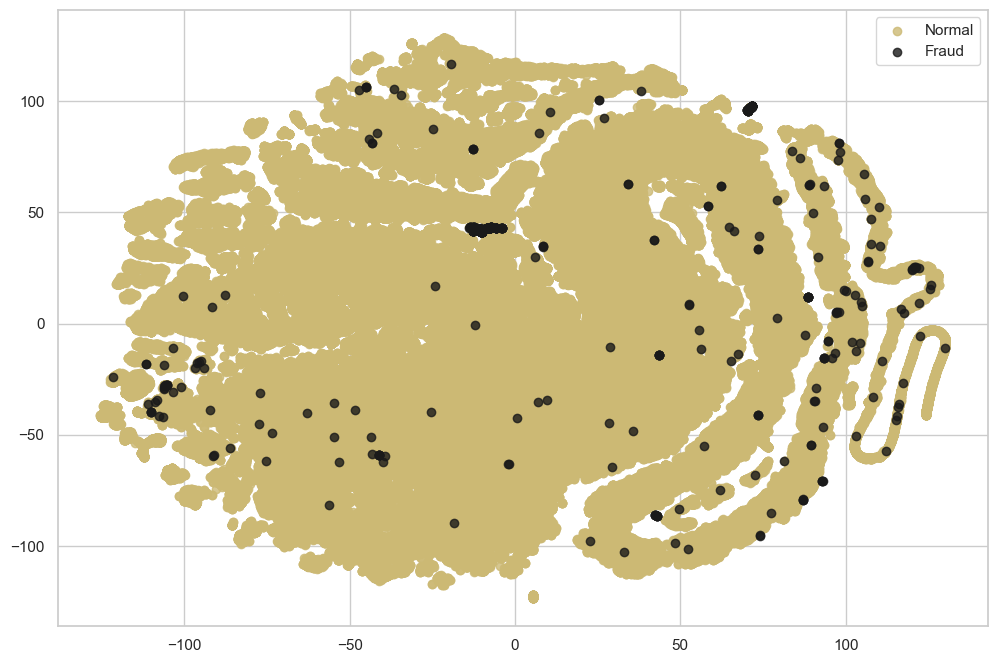

In [6]:
tsne_plot(X, y)

In [7]:
# Scaling the data to make it suitable for the auto-encoder 
X_scaled = MinMaxScaler().fit_transform(X) 
X_normal_scaled = X_scaled[y == 0] 
X_fraud_scaled = X_scaled[y == 1] 

## Building AutoEncoder

In [8]:
input_layer = tf.keras.layers.Input(shape = (X.shape[1], ))

# Encoder Network
encoded = tf.keras.layers.Dense(100, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_layer)
encoded = tf.keras.layers.Dense(50, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(encoded)
encoded = tf.keras.layers.Dense(25, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(encoded)
encoded = tf.keras.layers.Dense(12, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(encoded)
encoded = tf.keras.layers.Dense(6, activation='relu')(encoded)

# Decoder Network
decoded = tf.keras.layers.Dense(12, activation='tanh')(encoded)
decoded = tf.keras.layers.Dense(25, activation='tanh')(decoded)
decoded = tf.keras.layers.Dense(50, activation='tanh')(decoded)
decoded = tf.keras.layers.Dense(100, activation='tanh')(decoded)

output_layer = tf.keras.layers.Dense(X.shape[1], activation="relu")(decoded)

In [9]:
autoencoder = tf.keras.models.Model(input_layer, output_layer)
autoencoder.compile(optimizer = "adadelta", loss="mse")

call_back = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5)

autoencoder.fit(X_normal_scaled, X_normal_scaled, 
                batch_size = 16, epochs = 150, 
                shuffle = True, validation_split = 0.2, 
                callbacks = [])



Epoch 1/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 7s 524us/step - loss: 0.2335 - val_loss: 0.1458
Epoch 2/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 7s 532us/step - loss: 0.1406 - val_loss: 0.1297
Epoch 3/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 7s 534us/step - loss: 0.1275 - val_loss: 0.1223
Epoch 4/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 7s 528us/step - loss: 0.1212 - val_loss: 0.1187
Epoch 5/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 6s 513us/step - loss: 0.1184 - val_loss: 0.1178
Epoch 6/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 6s 511us/step - loss: 0.1177 - val_loss: 0.1174
Epoch 7/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 6s 518us/step - loss: 0.1173 - val_loss: 0.1171
Epoch 8/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 6s 510us/step - loss: 0.1170 - val_loss: 0.1168
Epoch 9/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 6s 516us/step - loss: 0.1167 - val_loss: 0.1166
Epoch 10/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 6s 515us/step - loss: 0.1165 - val_loss: 0.1164
Epoch 11/150
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 6s 516us/step - loss: 0

## Keep the Encoder Part of Data

In [10]:
hidden_representation = tf.keras.models.Sequential() 
hidden_representation.add(autoencoder.layers[0]) 
hidden_representation.add(autoencoder.layers[1]) 
hidden_representation.add(autoencoder.layers[2]) 
hidden_representation.add(autoencoder.layers[3]) 
hidden_representation.add(autoencoder.layers[4]) 

In [11]:
# Separating the points encoded by the Auto-encoder as normal and fraud 
normal_hidden_rep = hidden_representation.predict(X_normal_scaled)
fraud_hidden_rep = hidden_representation.predict(X_fraud_scaled)

# Combining the encoded points into a single table
encoded_X = np.append(normal_hidden_rep, fraud_hidden_rep, axis = 0) 
y_normal = np.zeros(normal_hidden_rep.shape[0]) 
y_fraud = np.ones(fraud_hidden_rep.shape[0]) 
encoded_y = np.append(y_normal, y_fraud)

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 1s 189us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


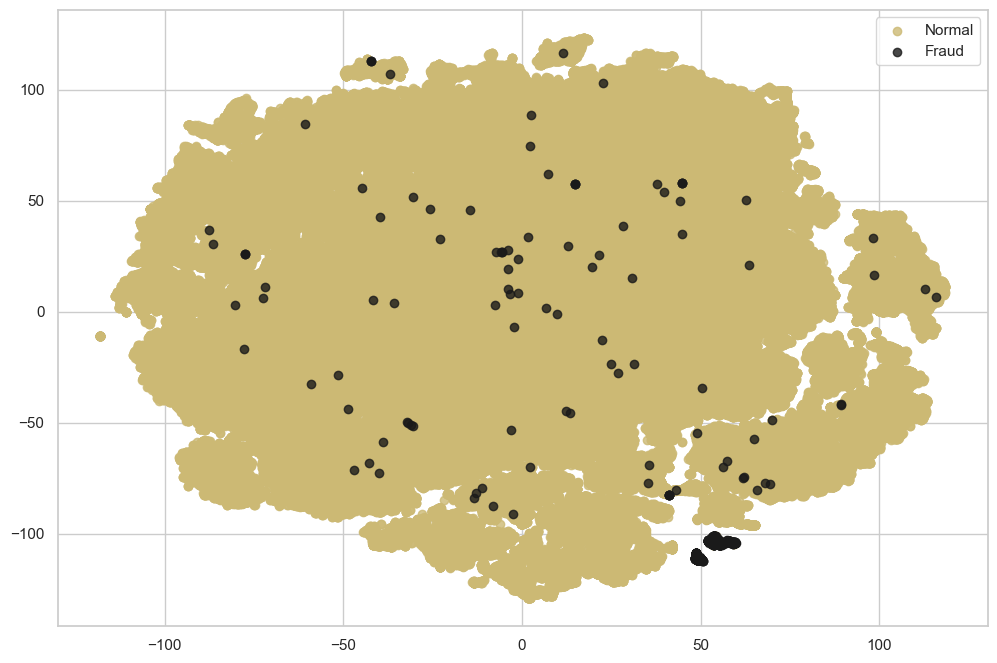

In [12]:
tsne_plot(encoded_X, encoded_y) 

## Logistic Regression with Encoded data

In [13]:
# Splitting the encoded data for linear classification 
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, encoded_y, test_size = 0.2) 
  
# Splitting the original data for non-linear classification 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

In [14]:
# Building the logistic regression model 
lrclf = LogisticRegression() 
lrclf.fit(X_train_encoded, y_train_encoded) 
  
# Storing the predictions of the linear model 
y_pred_lrclf = lrclf.predict(X_test_encoded) 

In [15]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test_encoded, y_pred_lrclf))


Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     49999
         1.0       0.75      0.21      0.33       100

    accuracy                           1.00     50099
   macro avg       0.87      0.60      0.66     50099
weighted avg       1.00      1.00      1.00     50099

